In [79]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.api.types import CategoricalDtype
import random
import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [50]:
data = pd.read_excel("Online Retail.xlsx")

In [51]:
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [53]:
# drop rows where customer id is absent
data.dropna(subset=['CustomerID'], inplace=True)

In [54]:
# item lookup table 
item_lookup = data.loc[:, ('StockCode', 'Description')]
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

In [55]:
item_lookup.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [56]:
# unique items
item_lookup.StockCode.nunique()

3684

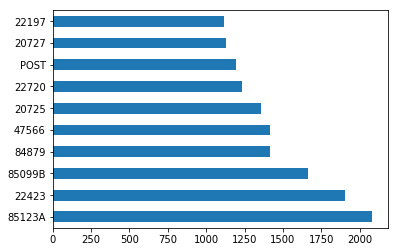

In [57]:
# item count in data set
item_lookup.StockCode.value_counts().head(10).plot(kind='barh')

In [58]:
data= data[data.Country == 'United Kingdom']

In [65]:
data['CustomerID'] = data.CustomerID.astype(int)
data['StockCode'] = data.StockCode.astype(object)
data = data.loc[:, ('StockCode', 'Quantity', 'CustomerID')]
grouped_cleaned = data.groupby(['CustomerID', 'StockCode']).sum().reset_index()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')

c:\users\ankit.dubey\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [66]:
grouped_purchased.head()

,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12747,20711,20
2,12747,21136,88
3,12747,21745,16
4,12747,21754,21


In [68]:
customers = list(np.sort(grouped_purchased.CustomerID.unique()))
products = list(grouped_purchased.StockCode.unique())
quantity = list(grouped_purchased.Quantity)

rows = grouped_purchased.CustomerID.astype(CategoricalDtype(customers)).cat.codes
cols = grouped_purchased.StockCode.astype(CategoricalDtype(products)).cat.codes
purchases_sparse = sparse.csr_matrix((quantity, (rows,cols)), shape=(len(customers), len(products)))

In [69]:
purchases_sparse

<3920x3644 sparse matrix of type '<class 'numpy.intc'>'
	with 237983 stored elements in Compressed Sparse Row format>

In [70]:
# sparsity
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1]
num_purchases = len(purchases_sparse.nonzero()[0])
sparsity = 100*(1-(num_purchases/matrix_size))
sparsity

98.3339750554448

In [72]:
import random
def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

In [75]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

This method is deprecated. Please use the AlternatingLeastSquares class instead


  0%|          | 0/50 [00:00<?, ?it/s]

In [78]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr) 

def calc_mean_auc(training_set, altered_users, predictions, test_set):      
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)

(0.868, 0.813)

In [80]:
customers_arr = np.array(customers) # Array of customer IDs from the ratings matrix
products_arr = np.array(products) # Array of product IDs from the ratings matrix

In [81]:
def rec_items(customer_id, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 10):
    '''
    This function will return the top recommended items to our users 
    
    parameters:
    
    customer_id - Input the customer's id number that you want to get recommendations for
    
    mf_train - The training matrix you used for matrix factorization fitting
    
    user_vecs - the user vectors from your fitted matrix factorization
    
    item_vecs - the item vectors from your fitted matrix factorization
    
    customer_list - an array of the customer's ID numbers that make up the rows of your ratings matrix 
                    (in order of matrix)
    
    item_list - an array of the products that make up the columns of your ratings matrix
                    (in order of matrix)
    
    item_lookup - A simple pandas dataframe of the unique product ID/product descriptions available
    
    num_items - The number of items you want to recommend in order of best recommendations. Default is 10. 
    
    returns:
    
    - The top n recommendations chosen based on the user/item vectors for items never interacted with/purchased
    '''
    
    cust_ind = np.where(customer_list == customer_id)[0][0] # Returns the index row of our customer id
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order 
    # of best recommendations
    rec_list = [] # start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Description.loc[item_lookup.StockCode == code].iloc[0]]) 
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'StockCode': codes, 'Description': descriptions}) # Create a dataframe 
    return final_frame[['StockCode', 'Description']] # Switch order of columns around


In [83]:
rec_items(12346, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,
                       num_items = 10)

,StockCode,Description
0,23167,SMALL CERAMIC TOP STORAGE JAR
1,23165,LARGE CERAMIC TOP STORAGE JAR
2,22982,PANTRY PASTRY BRUSH
3,23174,REGENCY SUGAR BOWL GREEN
4,23172,REGENCY TEA PLATE PINK
5,23175,REGENCY MILK JUG PINK
6,22978,PANTRY ROLLING PIN
7,23170,REGENCY TEA PLATE ROSES
8,23171,REGENCY TEA PLATE GREEN
9,22908,PACK OF 20 NAPKINS RED APPLES
